# Part 1

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# --- Load & time index ---
df = pd.read_csv(rf"C:\Users\anjal\Desktop\Fall 2025\Derivatives\Homework\Derivatives\HW2\etf_futures_1m_data.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)
df = df.set_index("Datetime").sort_index()

In [12]:
# --- Log-basis ---
df["SPX_log_basis"] = np.log(df["ES=F"]) - np.log(df["SPY"])
df["NDX_log_basis"] = np.log(df["NQ=F"]) - np.log(df["QQQ"])

In [13]:
# --- Daily stats ---
daily_stats = []
for day, g in df.groupby(df.index.date):
    daily_stats.append({
        "Date": day,
        "SPX_mean": g["SPX_log_basis"].mean(),
        "SPX_std":  g["SPX_log_basis"].std(),
        "SPX_min":  g["SPX_log_basis"].min(),
        "SPX_max":  g["SPX_log_basis"].max(),
        "SPX_count": len(g),

        "NDX_mean": g["NDX_log_basis"].mean(),
        "NDX_std":  g["NDX_log_basis"].std(),
        "NDX_min":  g["NDX_log_basis"].min(),
        "NDX_max":  g["NDX_log_basis"].max(),
        "NDX_count": len(g),
    })

daily_df = pd.DataFrame(daily_stats)

In [14]:
daily_df

,Date,SPX_mean,SPX_std,SPX_min,SPX_max,SPX_count,NDX_mean,NDX_std,NDX_min,NDX_max,NDX_count
0,2025-09-18,2.312840,0.000044,2.312710,2.313002,387,3.725377,0.000075,3.724096,3.725714,387
1,2025-09-19,2.315292,0.000113,2.315104,2.315521,390,3.725012,0.000089,3.724651,3.725252,390
2,2025-09-22,2.315134,0.000027,2.315041,2.315215,385,3.725997,0.000038,3.725901,3.726089,385
3,2025-09-23,2.314916,0.000039,2.314828,2.315063,390,3.725878,0.000030,3.725771,3.725963,390
4,2025-09-24,2.314897,0.000032,2.314797,2.314992,390,3.725840,0.000029,3.725755,3.726012,390
5,2025-09-25,2.314781,0.000034,2.314704,2.314888,390,3.725678,0.000028,3.725600,3.725786,390
6,2025-09-26,2.314444,0.000027,2.314371,2.314507,390,3.725299,0.000031,3.725189,3.725399,390


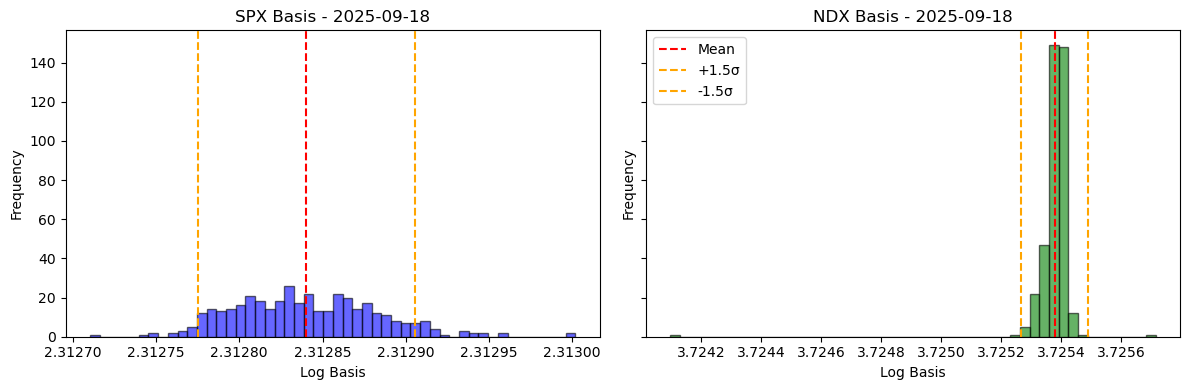

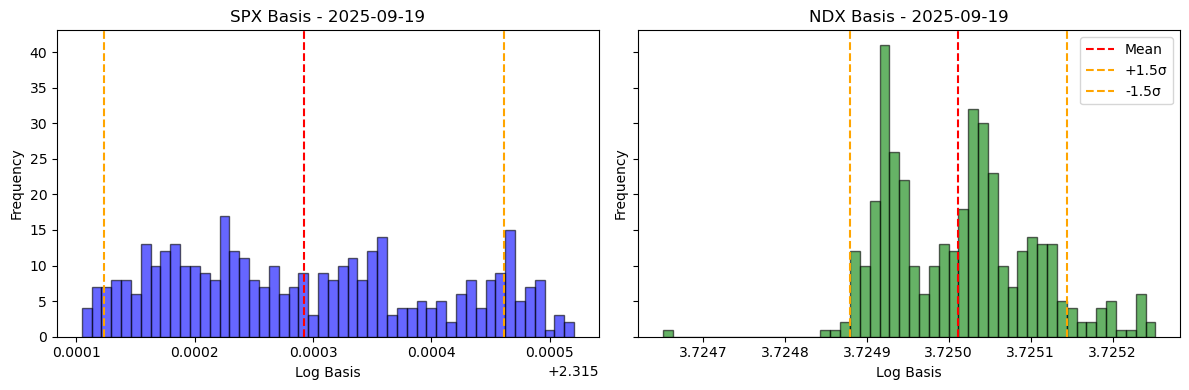

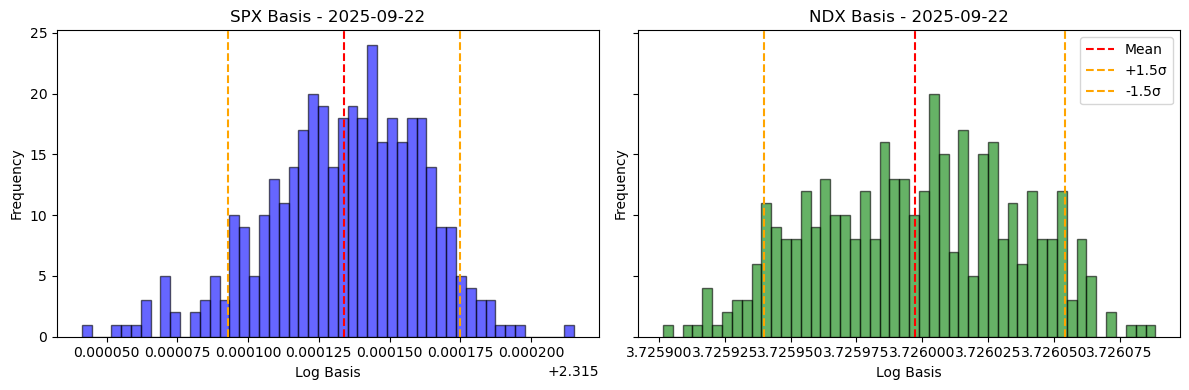

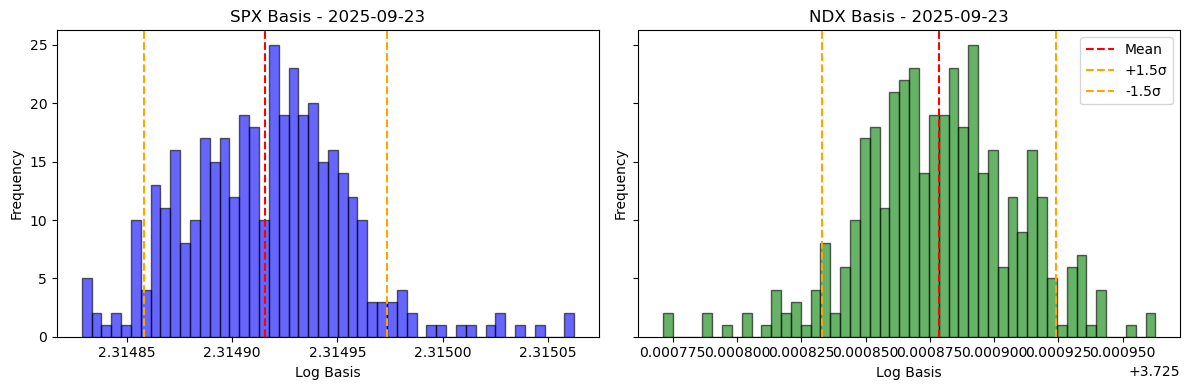

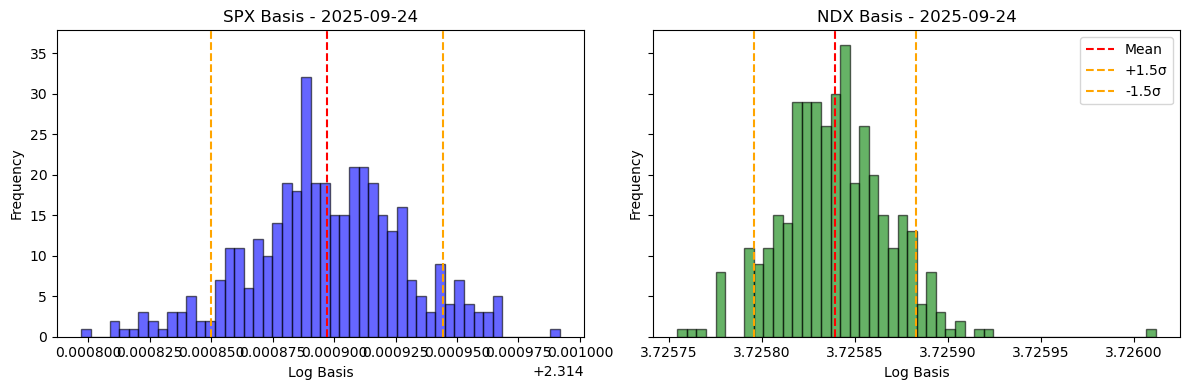

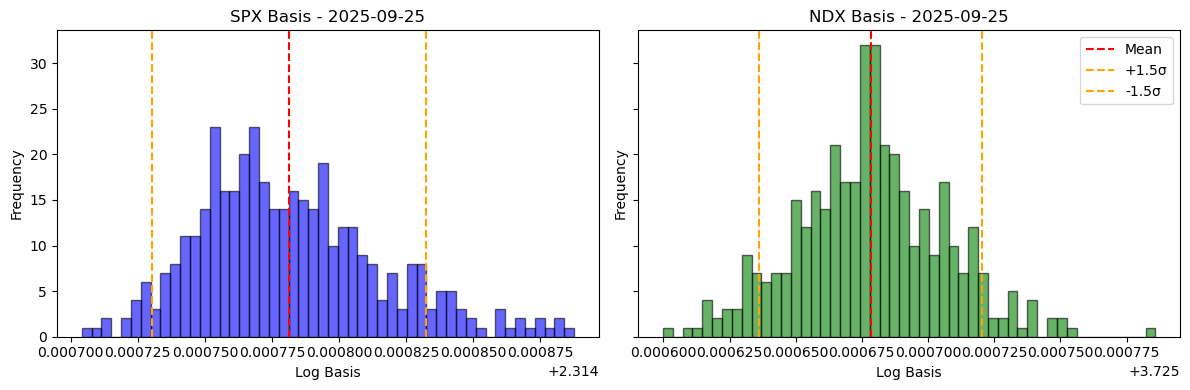

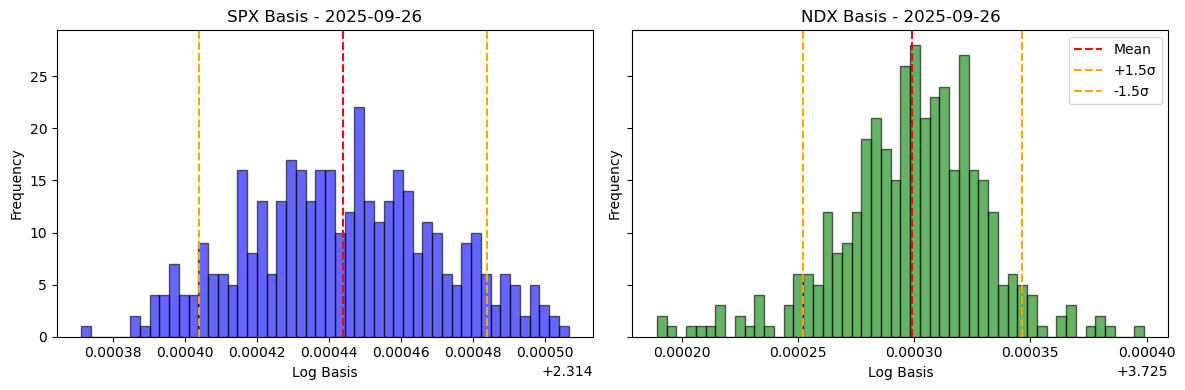

In [ ]:
for day, g in df.groupby(df.index.date):
    fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

    for ax, col, color in zip(axes, ["SPX_log_basis", "NDX_log_basis"], ["blue", "green"]):
        mean = g[col].mean()
        std  = g[col].std()

        ax.hist(g[col], bins=50, alpha=0.6, color=color, edgecolor="black")
        ax.axvline(mean, color="red", linestyle="--", label="Mean")
        ax.axvline(mean + 1.5*std, color="orange", linestyle="--", label="+1.5σ")
        ax.axvline(mean - 1.5*std, color="orange", linestyle="--", label="-1.5σ")

        ax.set_title(f"{col.split('_')[0]} Basis - {day}")
        ax.set_xlabel("Log Basis")
        ax.set_ylabel("Frequency")

    axes[1].legend()
    plt.tight_layout()
    plt.show()

### Note: 

- 9/19 was a "triple witching" day (quarterly expiry of index futures, index options, and single-stock options).
- On this day, September contracts rolled into December contracts → unusual rollover effects in futures pricing.
- It was also right after the 9/17 FOMC rate cut, adding extra volatility.
- Result: intraday basis was abnormally volatile → inflated std dev → thresholds too wide.
- To reflect "normal" trading conditions, we exclude 9/19 so that std estimates are not distorted by this anomaly.

In [16]:
# Drop all rows from 2025-09-19
df = df[df.index.date != pd.to_datetime("2025-09-19").date()]

# Part 2 trading rules (log-basis):
- Entry short basis (short fut / long ETF) when b_t > μ + 1.5σ
- Entry long basis  (long fut / short ETF) when b_t < μ - 1.5σ
- Exit when b_t returns inside ±1σ (or at market close)
- Positions sized to $1mm per leg at each day's open.
- We compute μ, σ from the FIRST HALF of that day; signals are applied to the SECOND HALF.


In [21]:
ES_MULT, NQ_MULT = 50, 20
NOTIONAL = 1_000_000

def trade_leg_day(g, *, basis_col, fut_col, etf_col, mult):
    """
    One trading day:
    - μ,σ from FIRST HALF of the day (training)
    - trade signals on SECOND HALF only (testing)
    - $1mm per leg, leg-based P&L from entry->exit, exit at ±1σ or EOD
    """
    if len(g) < 50:  # skip incomplete days
        return None

    n = len(g)
    first = g.iloc[: n//2]   # training half
    second = g.iloc[n//2: ]  # trading half

    # per-day thresholds (from FIRST HALF)
    mu = first[basis_col].mean()
    sigma = first[basis_col].std(ddof=1)
    upper      = mu + 1.5*sigma
    lower      = mu - 1.5*sigma
    exit_short = mu + 1.0*sigma
    exit_long  = mu - 1.0*sigma

    # $1mm per leg sized at the DAY OPEN 
    f_open = g[fut_col].iloc[0]
    e_open = g[etf_col].iloc[0]
    n_fut  = int(NOTIONAL / (f_open * mult))
    n_etf  = int(NOTIONAL / e_open)

    pos = 0  # +1 long basis (long fut/short etf), -1 short basis
    trades = 0
    day_pnl = 0.0
    durations = []

    f_entry = e_entry = None
    dur = 0

    # trade ONLY the second half
    for ts, row in second.iterrows():
        b = row[basis_col]

        if pos == 0:
            if b > upper:
                pos = -1; trades += 1; dur = 0
                f_entry = row[fut_col]; e_entry = row[etf_col]
            elif b < lower:
                pos = +1; trades += 1; dur = 0
                f_entry = row[fut_col]; e_entry = row[etf_col]
        else:
            dur += 1
            eod = (ts == second.index[-1])
            exit_signal = ((pos == -1 and b < exit_short) or
                           (pos == +1 and b > exit_long) or
                           eod)
            if exit_signal:
                f_exit = row[fut_col]; e_exit = row[etf_col]
                fut_leg = (f_exit - f_entry) * mult * n_fut
                etf_leg = (e_exit - e_entry) * n_etf
                spread_pnl = fut_leg - etf_leg
                day_pnl += (spread_pnl if pos == +1 else -spread_pnl)
                durations.append(dur)
                pos = 0
                f_entry = e_entry = None
                dur = 0

    avg_dur = float(np.mean(durations)) if durations else 0.0
    return {"Trades": trades, "AvgMinutes": avg_dur, "Daily_PnL": day_pnl}

def run_leg_strategy_per_day(df, basis_col, fut_col, etf_col, mult):
    rows = []
    for day, g in df.groupby(df.index.date):
        out = trade_leg_day(g, basis_col=basis_col, fut_col=fut_col, etf_col=etf_col, mult=mult)
        if out is not None:
            out["Date"] = pd.to_datetime(day)
            rows.append(out)
    if not rows:
        return pd.DataFrame(columns=["Date","Trades","AvgMinutes","Daily_PnL"]).set_index("Date")
    return pd.DataFrame(rows).set_index("Date")

def summarize(stats_df):
    return pd.Series({
        "Number of days": len(stats_df),
        "Average daily trades": stats_df["Trades"].mean() if len(stats_df) else 0.0,
        "Average duration per trade": stats_df["AvgMinutes"].mean() if len(stats_df) else 0.0,
        "Average daily P&L": stats_df["Daily_PnL"].mean() if len(stats_df) else 0.0,
        "Maximum daily P&L": stats_df["Daily_PnL"].max() if len(stats_df) else 0.0,
        "Minimum daily P&L": stats_df["Daily_PnL"].min() if len(stats_df) else 0.0,
        "Stdev of daily P&L": stats_df["Daily_PnL"].std(ddof=1) if len(stats_df) > 1 else 0.0,
    })

In [18]:
# --- Run on ALL days in df ---
spx_stats = run_leg_strategy_per_day(df, "SPX_log_basis", "ES=F", "SPY", ES_MULT)
ndx_stats = run_leg_strategy_per_day(df, "NDX_log_basis", "NQ=F", "QQQ", NQ_MULT)

spx_sum = summarize(spx_stats).rename("SPX")
ndx_sum = summarize(ndx_stats).rename("NDX")


In [20]:
# --- Combined portfolio ---
portfolio = pd.concat(
    [spx_stats["Daily_PnL"].rename("SPX"), ndx_stats["Daily_PnL"].rename("NDX")],
    axis=1
).fillna(0.0)
portfolio["Total_PnL"] = portfolio.sum(axis=1)
portfolio_sum = pd.Series({
    "Number of days": len(portfolio),
    "Average daily trades": (spx_stats["Trades"].mean() + ndx_stats["Trades"].mean()) / 2.0,
    "Average duration per trade": (spx_stats["AvgMinutes"].mean() + ndx_stats["AvgMinutes"].mean()) / 2.0,
    "Average daily P&L": portfolio["Total_PnL"].mean(),
    "Maximum daily P&L": portfolio["Total_PnL"].max() if len(portfolio) else 0.0,
    "Minimum daily P&L": portfolio["Total_PnL"].min() if len(portfolio) else 0.0,
    "Stdev of daily P&L": portfolio["Total_PnL"].std(ddof=1) if len(portfolio) > 1 else 0.0,
}, name="Portfolio")

final_summary = pd.concat([spx_sum, ndx_sum, portfolio_sum], axis=1)
final_summary

,SPX,NDX,Portfolio
Number of days,6.000000,6.000000,6.000000
Average daily trades,15.666667,14.000000,14.833333
Average duration per trade,4.688223,3.907856,4.298039
Average daily P&L,657.000997,587.794668,1244.795664
Maximum daily P&L,1682.427490,1084.671692,2495.438965
Minimum daily P&L,-400.751465,0.000000,-400.751465
Stdev of daily P&L,685.916953,409.686242,987.585844
